# Mapping Print, Charting Enlightenment

## Machine Learning Experiment 1: Classifying books by titles and other metadata

Team: Rachel Hendery, Tomas Trescak, Katie McDonough, Michael Falk, Simon Burrows

## Notebook 2: Converting titles to mean word vectors 

Author: Michael Falk

In this notebook, I experiment with converting each title into a 300-dimensional feature vector using Facebook's pre-trained French word vector model.

The model is large (~5GB), so has not been uploaded to the repository. All Facebook's pre-trained models are available here: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

The binary files FB provides do not work with the Gensim package, which makes them hard to use in python. I have compiled a new version of the bin file that does work with Gensim, which substantially decreases the load time. You can use this code to achieve this:

```python
from gensim.models import KeyedVectors
file_path = "fr_model/wiki.fr.vec" # locate .vec file
word_vectors = KeyedVectors.load_word2vec_format(file_path) # load into python
save_path = "fr_model/french_vectors.bin" # choose save path
word_vectors.save(save_path, binary = True) # save to it
```

The aim is to allow the model to generalise to unseen titles that have different words, as well as making the features more meaningful for the learning algorithm.

NB: If you're running this notebook on windows, you'll need to have a C compiler installed, and convince Python to use it. Otherwise gensim is very slow. 

In [2]:
# Load pre-trained word vectors
from gensim.models import KeyedVectors
import numpy as np
import time

file_path = "fr_model/french_vectors.bin"
tic = time.process_time()
word_vectors = KeyedVectors.load_word2vec_format(file_path, binary = True)
toc = time.process_time()
print ("Word vector model imported. Import took " + str(1000*(toc - tic)) + " milliseconds.")

Word vector model imported. Import took 35343.8 milliseconds.


In [3]:
# Sanity check - does word_vectors return a 300-dimensional vector as intended?
# (Actually it is a 1d numpy array)
word_vectors["écraser"].shape

(300,)

In [4]:
# Load training data and preprocess
import pandas as pd # library for manipulating data
from nltk.tokenize import wordpunct_tokenize # tokeniser
import re # regular expressions

data_path = "data/editions_trimmed.csv" # locate data file

data = pd.read_csv(data_path).dropna()
title_strings = [] # initialise list of word vectors
for title in data["full_book_title"]: # loop over titles
    title = title.lower() # make all letters lower case
    tokens = wordpunct_tokenize(title) # tokenise
    reg1 = re.compile("\w") # regex for finding tokens with letters
    reg2 = re.compile("\D") # regex for finding tokens with numbers
    filtered = [i for i in tokens if reg1.search(i)] # strip out punctuation
    filtered = [i for i in filtered if reg2.search(i)] # strip out numbers
    filtered = [i for i in filtered if len(i) > 2] # strip out stopwords TODO: get proper sw list
    title_strings.append(filtered) # append to results list

In [5]:
# Sanity check: how does a random title look?
import random
title_strings[random.randint(1,len(title_strings))]

['expériences',
 'observations',
 'sur',
 'différentes',
 'espèces',
 'air',
 'ouvrage',
 'traduit',
 'anglois',
 'priestley',
 'par',
 'gibelin']

The next step could do with some investigation. From my reading, it is apparently legit to calculate the word embeddings for a whole sentence by getting the word vectors for each word and then averaging them. We will see if this enables the model to train effectively. 

In [6]:
# Get word vectors for each title
import numpy as np

def get_mean_word_vec(string_list, word_vectors):
    '''
    params:
    
        string_list: a list of strings
        word_vectors: a KeyedVectors object (gensim)
        
        dependencies: numpy, gensim
    
    desc:
    
    This function takes a list of strings and a KeyedVectors
    object as arguments. It first computes the word vectors for
    each string in the list, according to the provided model.
    It then takes the mean of the all the vectors. It returns a
    single vector, whose dimensionality is determined by the
    provided model.
    '''
    n = word_vectors.vector_size # how many dimensions are the word vectors?
    W = np.empty((n,0)) # initialise title matrix
    
    for word in string_list: # loop through strings
        if word in word_vectors.vocab: # check if word is in vocab.
            w = word_vectors[word].reshape((n,1)) # if it is, find the vector and check the dimensions
            W = np.c_[W, w] # add as column to title matrix
    
    # take the sum of each row and reshape to a row vector
    title_vector = np.nanmean(W, axis = 1).reshape((1,n))
    
    # title_vector is an 1 x n feature vector of the whole title
    
    return title_vector

In [47]:
# Loop through examples and apply the function.
# NB: this produces an error 'Mean of empty slice', which is caused by books that have unparseable words

n = word_vectors.vector_size # how many dimensions do our training examples have?
X = np.empty((0,n)) # initialise design matrix
error_titles = []

for i in range(0, len(title_strings)):
    try:
        title_vector = get_mean_word_vec(title_strings[i], word_vectors) # get mean vector
    except:
        print("Mean vector could not be calculated for title %d" % i) # catch error
        break
    finally:
        if np.all(np.isnan(title_vector)) == False: # if a title vector is returned...
            X = np.r_[X, title_vector] # ... add it to the design matrix.
        else: # if not...
            error_titles.append(i) # ... add it to the list of titles that caused an error.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


Now we have a matrix, X, with one row for each book, and 300 columns for the means of each word vector feature. 14 of the titles could not be parsed, as can be seen in the cell below. They are all titles with foreign or idiosyncratic names, and most of them were never assigned a parisian keyword.

In [40]:
data.iloc[error_titles]

# The row numbers printed below are all wrong, because pandas retains row numbers
# when you drop NaNs.

,full_book_title,stated_publication_places,number_of_volumes,parisian_keyword
206,[Bonnetre],n.pl.,1,Undetermined
217,[Carloine],n.pl.,2,Undetermined
636,[Zunia],n.pl.,1,Undetermined
2106,[Lettri di Pesseri],n.pl.,1,Undetermined
2185,[Parlemang],n.pl.,1,Belles-Lettres
2486,[l'Enotenus],n.pl.,1,Undetermined
2580,[Morhieu],n.pl.,1,Undetermined
2695,[Ferben neüe Beytrage],n.pl.,1,Undetermined
2698,[Färb n bleick],n.pl.,1,Undetermined
2867,[Soubzers],n.pl.,2,Undetermined


In [66]:
# Finally get the ground truth data for the 3824 examples that could be parsed.
# Pandas is really stupid and doesn't let you filter out rows by index, as far as I can tell...

seq = list(range(0,len(data))) # generate sequence of row numbers
to_keep = [i for i in seq if i not in error_titles] # remove the titles that could not be parsed

y = np.array(data["parisian_keyword"].iloc[to_keep])

# Sanity check:
print("The shape of y is " + str(y.shape))
print("The shape of X is " + str(X.shape))

The shape of y is (3824,)
The shape of X is (3824, 300)


Now we can export the design matrix and ground truth data for use in a Colab Notebook.

In [49]:
import pickle

title_vector_data = {"X": X, "y": y}

pickle.dump(title_vector_data, open("data/title_vector_data.p", "wb"))

Before we get onto training some serious models, let's have one last look at logistic regression.

In [53]:
# A function for plotting the confusion matrix, copied from scikit-learn.org
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
# Split into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=2)

# Use sklearn's logistic regression model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
lg = OneVsRestClassifier(estimator = LogisticRegression(max_iter = 1000), n_jobs = 2) # initialise classifier
lg.fit(X_train, y_train) # fit to the training data
predictions = lg.predict(X_test) # compute predictions for the test data


 
The model classified 717 of the 956 examples correctly.
Accuracy = 75.2%


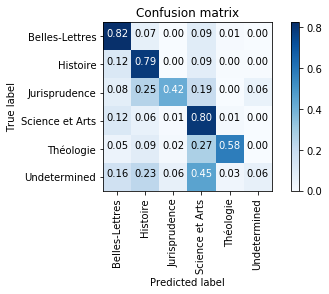

In [69]:
# Compute confusion matrix and accuracy
correct = predictions == y_test
accuracy = correct.sum()/len(correct)*100
print("\n \nThe model classified %d of the %d examples correctly." % (correct.sum(), len(correct)))
print("Accuracy = %d.2%%" % accuracy)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
plt.figure()
plot_confusion_matrix(cm, classes=lg.classes_, normalize = True)
plt.show()


 
The model classified 570 of the 956 examples correctly.
Accuracy = 59.2%


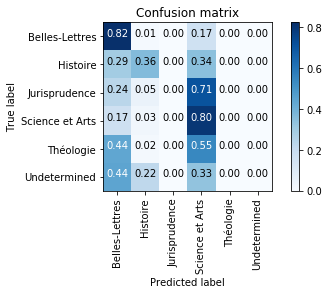

In [76]:
# Or we could try an SVM.
from sklearn.svm import SVC

model = SVC().fit(X_train, y_train) # train the model
pred_svm = model.predict(X_test) # compute predictions for test set
correct = pred_svm == y_test # find correct predictions
accuracy = correct.sum()/len(correct)*100 # calculate the accuracy

print("\n \nThe model classified %d of the %d examples correctly." % (correct.sum(), len(correct)))
print("Accuracy = %d.2%%" % accuracy)

cm_svm = confusion_matrix(y_test, pred_svm)
plt.figure()
plot_confusion_matrix(cm_svm, classes=model.classes_, normalize = True)
plt.show()

These models don't seem to do any better than the original. I find this quite interesting, because I thought that the model trained on word vectors would generalise much better to new titles that have unfamilar words.

Let's see if a neural net can do a better job.